In [2]:
import warnings
warnings.filterwarnings("ignore")

import torch
import scvi
import scanpy as sc
import matplotlib.pyplot as plt
import warnings
import numpy as np
import anndata
import pandas as pd
from scipy.sparse import hstack

In [3]:
#load the data we generated using signac_and_dataFormat_manipulation_demo.R
adata_atac = scvi.data.read_10x_multiome("ccRCC_ATAC")
adata_rna = scvi.data.read_10x_multiome("ccRCC_RNA")

In [4]:
#creating the pseudo paired peak-gene anndata object for this demo
adata_pair_X=hstack((adata_rna.X,adata_atac.X))
adata_pair_var=pd.concat([adata_rna.var,adata_atac.var])
adata_pair=anndata.AnnData(adata_pair_X,obs=adata_rna.obs,var=adata_pair_var)

In [5]:
#subsampling a small number of cells, so that we can finish running this demo 
#in hours on a home computer without GPU/cuda support 
adata_pair_subset= adata_pair[0:100].copy()
adata_atac_subset= adata_atac[100:200].copy()
adata_rna_subset= adata_rna[200:300].copy()

In [6]:
#add the modality to the observations
adata_pair_subset.obs["modality"]= "paired"
adata_atac_subset.obs["modality"]= "peaks"
adata_rna_subset.obs["modality"]= "expression"

In [7]:
#set up the multiome and MultiVI training anndata structure
adata_mvi = scvi.data.organize_multiome_anndatas(adata_pair_subset,
                                                 rna_anndata=adata_rna_subset,
                                                 atac_anndata=adata_atac_subset,
                                                 modality_key='modality')

scvi.model.MULTIVI.setup_anndata(adata_mvi, batch_key='modality')

In [8]:
#define the training model
mvi = scvi.model.MULTIVI(
    adata_mvi,
    n_genes=(adata_pair_subset.var['modality']=='expression').sum(),
    n_regions=(adata_pair_subset.var['modality']=='peaks').sum(),
)

In [9]:
#double check the setup 
mvi.view_anndata_setup()

Anndata setup with scvi-tools version 0.17.1.

Setup via `MULTIVI.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'modality',
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│          n_vars          │ 140301 │
│         n_cells          │  300   │
│         n_batch          │   3    │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
└──────────────────────────┴────────┘

               Data Registry               
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃   scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │         adata.X          │
│    batch     │ adata.obs['_scvi_batch'] │
└──────────────┴──────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃  Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['modality'] │ accessibility │          0          │
│                       │  expression   │          1          │
│                       │    paired     │          2          │
└───────────────────────┴───────────────┴─────────────────────┘

In [10]:
#train the MultiVI model
mvi.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 371/500:  74%|████████████████████████████████████████████████████▋                  | 371/500 [50:59<17:43,  8.25s/it, loss=8.85e+03, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 21502.785. Signaling Trainer to stop.


In [11]:
#load the latent representation
adata_mvi.obsm["MultiVI_latent"] = mvi.get_latent_representation()

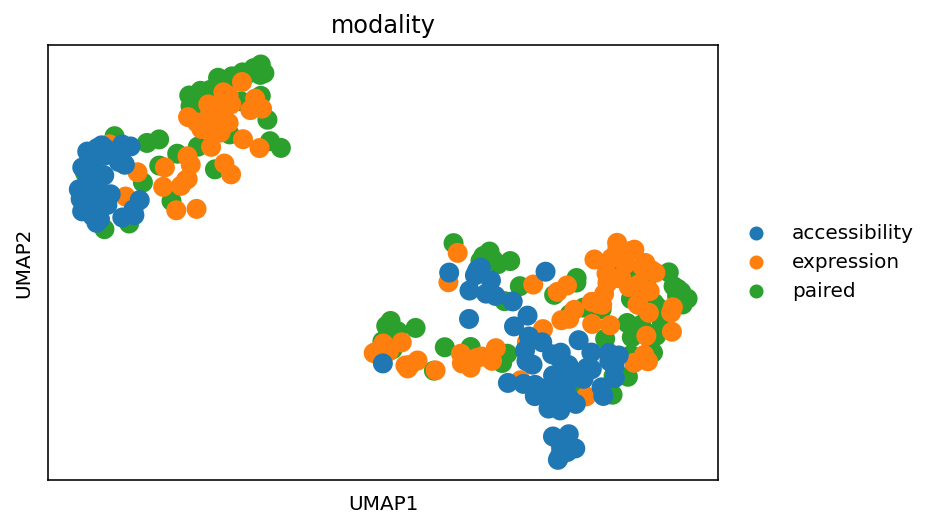

In [14]:
#visualization
sc.pp.neighbors(adata_mvi, use_rep="MultiVI_latent")
sc.tl.umap(adata_mvi, min_dist=0.2)
sc.pl.umap(adata_mvi, color='modality')